In [87]:
import os
from dotenv import load_dotenv
from pathlib import Path
from typing import Literal, Annotated
from typing_extensions import TypedDict
import re
import json
from datetime import datetime
from collections import defaultdict

from pydantic import BaseModel, Field

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import MessagesState, StateGraph, END, START
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_core.tools import tool, render_text_description_and_args
from langchain_core.prompts import (
    ChatPromptTemplate,
)
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.documents import Document

#from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from sentence_transformers import SentenceTransformer

from IPython.display import Image, display

In [88]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import InMemoryVectorStore
from langchain_huggingface import HuggingFaceEmbeddings
from transformers import AutoTokenizer

In [89]:
load_dotenv()
api_key = os.getenv("API_GROQ")
model_LLM = "llama-3.1-8b-instant"
model_embedding = "intfloat/multilingual-e5-small"

In [90]:
llm = ChatOpenAI(
    base_url="https://api.groq.com/openai/v1",
    api_key=api_key,
    model="llama-3.1-8b-instant", #"llama-3.3-70b-versatile"
    temperature=0
)

In [91]:
def display_graph(graph: CompiledStateGraph):
    display(Image(graph.get_graph().draw_mermaid_png()))

In [92]:
with open(Path("goal_notes.json"), "r", encoding="utf-8") as f:
    data = json.load(f)

data = data['entries']

In [93]:
class DateDict(TypedDict, total=False):
    month: int | None
    year: int
    week: int | None

class SummarizingDict(TypedDict, total=False):
    notes: list[dict[str, list]]
    summary: list[str]
    valid: list[bool]

class RetrievalDict(TypedDict, total=False):
    context: list
    final_context: list[str]

class ReportState(MessagesState, total=False):
    period: Literal['week', 'month', 'year']
    date: DateDict
    data: dict
    summarizing: SummarizingDict
    retrieval: RetrievalDict
    final_report: str

# Summary

In [94]:
'''id-goals
1-спорт
2-Python
3-іспанська
'''

'id-goals\n1-спорт\n2-Python\n3-іспанська\n'

In [95]:
def retrieve_by_period(state: ReportState) -> list[dict]:
    notes = []
    period = state['period']
    data = state['data']
    year = state['date']['year']

    if period == 'year':
        period_notes = [
            item for item in data if datetime.strptime(item["date"], "%Y-%m-%d").year == year
        ]
    elif period == 'month':
        month = state['date']['month']
        period_notes = [
            item for item in data
            if datetime.strptime(item["date"], "%Y-%m-%d").month == month
            and datetime.strptime(item["date"], "%Y-%m-%d").year == year
        ]
    else:
        week = state['data']['week']
        period_notes = [
            item for item in data
            if datetime.strptime(item["date"], "%Y-%m-%d").month == month
            and datetime.strptime(item["date"], "%Y-%m-%d").isocalendar()[1] == week
        ]

    notes_by_goal = defaultdict(list)
    for item in period_notes:
        if 'id-goal' in item and 'notes' in item:
            notes_by_goal[item['id-goal']].append(item['notes'])

    notes = [
        {'name': goal, 'notes': note_list} 
        for goal, note_list in notes_by_goal.items()
    ]
    return {"summarizing": {"notes": notes}}

In [96]:
def create_summary(state: ReportState):
    notes = state['summarizing']['notes']
    prompt = """
    Створи стислий summary досягнень за період.
    Записи: {}
    Фокус на прогресі та patterns.
    """

    summaries = []
    for goal in notes:    
        summaries.append(llm.invoke(prompt.format(goal['notes'])).content)

    return {"summarizing": {"summary": summaries}}

# RAG

## Embedding pipeline

In [97]:
class GroundingState(TypedDict, total=False):
    data: dict = {}
    texts: list = []
    chunks: list = []
    vector_store: None
    status: str = ""

In [98]:
hf_model = HuggingFaceEmbeddings(
    model_name=model_embedding,
    encode_kwargs={
        "batch_size": 8
    }
)

In [99]:
def load_documents(state: GroundingState):
    data = state['data']
    print(type(data))
    print(data)

    docs = []
    
    for note in data:
        docs.append(Document(
            page_content=note['notes'],
            metadata={
                "date": note['date'],
                "goal_id": note['id-goal'],
                "productivity_score": note['productivity-score']
            }
        ))
    print(f"Created {len(docs)} docs")
    return {"texts": docs, "status": "loaded"}

In [100]:
def index_documents(state: GroundingState):
    docs = state["texts"]
    print(f"Indexing {len(docs)} chunks...")
    vector_store = InMemoryVectorStore.from_documents(
        docs,
        hf_model
    )
    return {"vector_store": vector_store, "status": "indexed"}

In [101]:
grounding_graph_n = StateGraph(GroundingState)
grounding_graph_n.add_node("load", load_documents)
grounding_graph_n.add_node("index", index_documents)

grounding_graph_n.add_edge("load", "index")
grounding_graph_n.add_edge("index", END)

grounding_graph_n.set_entry_point("load")
grounding_pipeline_n = grounding_graph_n.compile()

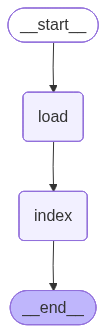

In [102]:
display_graph(grounding_pipeline_n)

In [103]:
result = grounding_pipeline_n.invoke({"data": data})
print(result['status'])
embeddings = result['vector_store']

<class 'list'>
[{'id-entry': '1', 'id-goal': '1', 'date': '2025-12-03', 'notes': "Нарешті записався в спортзал! Трохи нервувався, але тренер виявився дуже привітним. Зробив легке кардіо та розминку, м'язи вже трохи болять.", 'productivity-score': 4}, {'id-entry': '2', 'id-goal': '1', 'date': '2025-12-06', 'notes': 'Друге тренування пройшло важче, ніж очікував. Ледве доробив усі підходи, але почуваюся задоволеним. Важливо не здаватися!', 'productivity-score': 3}, {'id-entry': '3', 'id-goal': '1', 'date': '2025-12-10', 'notes': 'Сьогодні пропустив тренування через роботу, відчуваю провину. Потрібно краще планувати свій час.', 'productivity-score': 1}, {'id-entry': '4', 'id-goal': '1', 'date': '2025-12-13', 'notes': 'Повернувся до тренувань! Додав трохи більше ваги на присіданнях. Відчуваю, що стаю сильнішим.', 'productivity-score': 5}, {'id-entry': '5', 'id-goal': '1', 'date': '2025-12-17', 'notes': 'Перший раз пробіг 3 км без зупинки. Не вірю, що це я! Дихання ще важке, але прогрес очев

## Retrieval pipeline

In [104]:
def retrieve_documents(state: ReportState):
    summaries = state["summarizing"]["summary"]
    relevant_lists = []

    for summary in summaries:
        relevant_docs = embeddings.similarity_search(
            summary,
            k=5
        )
        relevant_lists.append(relevant_docs)

    
    return {"retrieval": {"context": relevant_lists}}

In [105]:
def check_relevance(state: ReportState):
    summaries = state["summarizing"]["summary"]
    docs_lists = state["retrieval"]['context']
    final_context = []

    for summary, docs in zip(summaries, docs_lists):
        context = []
        for doc in docs:
            relevance_prompt = f"""
        Ти — суворий класифікатор, а не помічник.

        Твоє завдання — визначити, чи підходить контекст для порівняння з підсумками.

        Контекст:
        {doc}

        Підсумок: {summary}

        ВІДПОВІДАЙ ТІЛЬКИ:
        - "1" — якщо на основі контексту можна порівняти результати з тими що у підсумку.
        - "0" — якщо контекст не підходить.

        Будь суворим.

        Відповідь ТІЛЬКИ числом: 1 або 0.
        """

            response = llm.invoke([HumanMessage(content=relevance_prompt)])
            answer = response.content.strip().upper()
            is_relevant = answer.startswith("1")
            if is_relevant == True:
                context.append(doc.page_content)
        final_context.append(context)

    return {"retrieval": {"final_context": final_context}}

# Report pipeline

In [106]:
def create_report(state: ReportState):
    summaries = state["summarizing"]["summary"]
    past_contexts = state['retrieval']['final_context']
    
    formatted_summaries = []
    for i, summary in enumerate(summaries, 1):
        formatted_summaries.append(f"Ціль {i}:\n{summary}")
    current_summary_text = "\n\n".join(formatted_summaries)
    
    formatted_contexts = []
    for i, context_list in enumerate(past_contexts, 1):
        context_text = "\n".join(context_list)
        formatted_contexts.append(f"Минуле досягнення {i}:\n{context_text}")
    
    past_context_text = "\n\n".join(formatted_contexts) if formatted_contexts else "Минулі дані відсутні"
    
    if len(summaries) == len(past_contexts):
        comparisons = []
        for i, (current, past) in enumerate(zip(summaries, past_contexts), 1):
            past_text = "\n".join(past) if isinstance(past, list) else str(past)
            comparisons.append(f"""
### Ціль {i}

**Поточний стан:**
{current}

**Минулі досягнення:**
{past_text}
""")
        comparison_section = "\n".join(comparisons)
    else:
        comparison_section = f"""
## Поточні досягнення:
{current_summary_text}

## Минулі досягнення для порівняння:
{past_context_text}
"""
    
    prompt = f"""
Ти — мотиваційний коуч, який аналізує прогрес користувача.

{comparison_section}

## Завдання:
1. Проаналізуй КОЖНУ пару: поточне досягнення vs минуле
2. Визнач конкретний прогрес або регрес
3. Знайди patterns і тенденції
4. Створи мотиваційний звіт

## Структура звіту:
**Загальний огляд:**
- Скільки цілей в роботі
- Загальна динаміка

**По кожній цілі:**
- Що зроблено зараз
- Як це порівнюється з минулим
- Висновок про прогрес

**Мотиваційний висновок:**
- Головні досягнення
- Що працює добре
- Підбадьорлива нотатка

Використовуй ТІЛЬКИ надану інформацію. Будь конкретним та позитивним.
"""

    report = llm.invoke(prompt)
    return {"final_report": report.content}

In [107]:
def route_based_on_period(state: ReportState):
    if state["period"] == 'week':
        return "report"
    else:
        return "retrieve"

In [108]:
report_graph = StateGraph(state_schema=ReportState)
report_graph.add_node("take_notes", retrieve_by_period)
report_graph.add_node("summary", create_summary)

report_graph.add_node("retrieve", retrieve_documents)
report_graph.add_node("check_relevance", check_relevance)

report_graph.add_node("report", create_report)

report_graph.add_edge("take_notes", "summary")
report_graph.add_conditional_edges(
    "summary",
    route_based_on_period,
    {
        "report": "report",
        "retrieve": "retrieve"
    }
)
report_graph.add_edge("retrieve", "check_relevance")
report_graph.add_edge("check_relevance", "report")
report_graph.add_edge("report", END)

report_graph.set_entry_point(
    "take_notes"
)

report_pipeline = report_graph.compile()

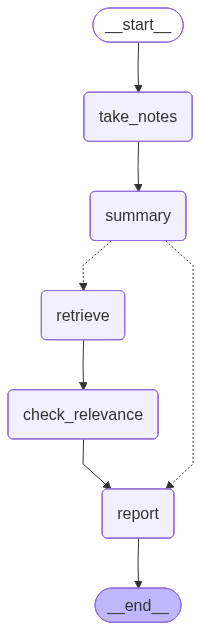

In [109]:
display_graph(report_pipeline)

In [110]:
'''state = {
    period: Literal['week', 'month', 'year'],
    date: {
        month: int | None,
        year: int,
        week: int | None
    },
    data,
    summarizing: {
        notes: list[dict[str, list]]
        summary: list[str]
        valid: list[bool]
    },
    retrieval:{
        context: list
        "final_context": list[str]}
    },
}'''

'state = {\n    period: Literal[\'week\', \'month\', \'year\'],\n    date: {\n        month: int | None,\n        year: int,\n        week: int | None\n    },\n    data,\n    summarizing: {\n        notes: list[dict[str, list]]\n        summary: list[str]\n        valid: list[bool]\n    },\n    retrieval:{\n        context: list\n        "final_context": list[str]}\n    },\n}'

In [111]:
report = report_pipeline.invoke({
    "period": "month",
    "date": {
        "month": 12,
        "year": 2025
    },
    "data": data
})

In [114]:
print(report['final_report'])

**Загальний огляд:**

У роботі представлені три цілі: фізична підготовка, вивчення програмування Python і вивчення іспанської мови. За період спостереження спостерігається значний прогрес у всіх трьох цілях.

**Ціль 1: Фізична підготовка**

* **Поточний стан:** Автор відчуває зростання фізичної сили, постійність тренувань та зміну поведінки.
* **Минуле:** Автор відвідував тренування майже щотижня, відчував зростання фізичної сили та здатності виконувати більше підходів.
* **Прогрес:** Автор відчуває більший прогрес у фізичній підготовці, ніж раніше. Він відчуває більшу фізичну силу та здатність виконувати більше підходів.
* **Тенденція:** Автор продовжує відвідувати тренування майже щотижня, що свідчить про постійність та бажання досягти своїх цілей.

**Ціль 2: Вивчення програмування Python**

* **Поточний стан:** Автор вивчає програмування Python, вивчає вкладені цикли, працює зі списками та вивчає онлайн курси.
* **Минуле:** Автор почав вивчати програмування Python, вивчив вкладені ц